

---


`This project demonstrates the end-to-end workflow for claims frequency and severity modelling on synthetic UK car insurance data. The focus is on process clarity, feature importance analysis, and transparent discussion of modelling results and limitations.`


---



# Generate Dataset

In [2]:
!pip install imbalanced-learn

In [36]:
import pandas as pd
import numpy as np
import random
import datetime

# CONFIG: Set number of rows
number_of_rows = 10000

# Reference lists
uk_regions = [
    'Manchester', 'London', 'Birmingham', 'Leeds', 'Glasgow', 'Liverpool',
    'Bristol', 'Cardiff', 'Belfast', 'Edinburgh', 'East Midlands', 'West Midlands'
]
occupations = [
    'Teacher', 'Engineer', 'Retail Staff', 'Healthcare Worker', 'IT Professional',
    'Driver', 'Construction Worker', 'Accountant', 'Student', 'Retired'
]
credit_scores = ['Poor', 'Fair', 'Good', 'Excellent']
makes_models = [
    'Ford Fiesta', 'Vauxhall Astra', 'Volkswagen Golf', 'BMW 3 Series',
    'Audi A3', 'Nissan Qashqai', 'Toyota Yaris', 'Honda Civic', 'Kia Sportage'
]
modifications = ['None', 'Performance', 'Aesthetic', 'Safety']
fuel_types = ['Petrol', 'Diesel', 'Electric', 'Hybrid']
coverage_types = ['Comprehensive', 'Third-party only', 'Third-party, fire and theft']
durations = ['6 months', '12 months']
incident_types = ['Collision', 'Theft', 'Fire', 'Vandalism', 'Weather Damage']
fault_status = ['At fault', 'Not at fault']
claim_outcomes = ['Approved', 'Rejected', 'Pending']
weather_conditions = ['Clear', 'Rain', 'Snow', 'Fog']
road_types = ['Urban', 'Rural', 'Motorway']
marital_statuses = ['Single', 'Married', 'Divorced', 'Widowed']
genders = ['Male', 'Female', 'Other']

rows = []
start_date = datetime.date(2015, 1, 1)
end_date = datetime.date.today()
days_between_dates = (end_date - start_date).days

for _ in range(number_of_rows ):
    # POLICYHOLDER INFO
    age = np.random.randint(18, 91)
    gender = random.choices(genders, weights=[0.48,0.48,0.04])[0]
    location = random.choice(uk_regions)
    occupation = random.choice(occupations)
    marital = random.choices(marital_statuses, weights=[0.4,0.45,0.1,0.05])[0]
    credit = random.choices(credit_scores, weights=[0.2,0.3,0.35,0.15])[0]

    # VEHICLE INFO
    make_model = random.choice(makes_models)
    year_manufacture = np.random.randint(1995, 2026)
    engine_size = round(np.random.uniform(1.0, 3.5),1)
    vehicle_value = round(np.random.uniform(500,50000),2)
    modification = random.choices(modifications, weights=[0.7,0.1,0.1,0.1])[0]
    fuel = random.choices(fuel_types, weights=[0.5,0.3,0.1,0.1])[0]
    vehicle_group = np.random.randint(1,51)

    # INSURANCE POLICY
    coverage = random.choices(coverage_types, weights=[0.7,0.15,0.15])[0]
    duration = random.choice(durations)

    base_premium = 300
    age_factor = 1.5 if age < 25 else (1.2 if age < 35 else 1.0)
    group_factor = 1 + (vehicle_group/50)
    credit_factor = {'Poor':1.5,'Fair':1.2,'Good':1.0,'Excellent':0.8}[credit]
    premium_amount = round(base_premium * age_factor * group_factor * credit_factor,2)

    no_claims_bonus = np.random.randint(0,16)
    num_claims = np.random.poisson(0.5)
    avg_claim_value = round(np.random.uniform(200,5000),2) if num_claims>0 else 0
    most_freq_claim_type = random.choice(incident_types)

    if num_claims > 0:
        random_days = random.randrange(days_between_dates)
        date_of_claim = start_date + datetime.timedelta(days=random_days)
        incident = random.choice(incident_types)
        fault = random.choice(fault_status)

        # NEW LOGIC: claim amount depends on incident and vehicle
        incident_multipliers = {
            'Collision': 0.2,
            'Theft': 0.3,
            'Fire': 0.4,
            'Vandalism': 0.15,
            'Weather Damage': 0.25
        }
        fault_multiplier = 1.2 if fault == 'At fault' else 0.8
        base_claim = vehicle_value * incident_multipliers[incident]
        noise = np.random.normal(loc=0, scale=200)
        claim_amount = max(200, round(base_claim * fault_multiplier + noise, 2))

        claim_outcome = random.choices(claim_outcomes, weights=[0.8,0.1,0.1])[0]
        weather = random.choices(weather_conditions, weights=[0.6,0.3,0.05,0.05])[0]
        road = random.choice(road_types)
    else:
        date_of_claim = ''
        incident = ''
        fault = ''
        claim_amount = ''
        claim_outcome = ''
        weather = ''
        road = ''

    accident_rate = round(np.random.uniform(1,20),2)
    theft_rate = round(np.random.uniform(0.5,15),2 if location in ['London','Manchester','Liverpool'] else 1)

    row = {
        'Age': age,
        'Gender': gender,
        'Location': location,
        'Occupation': occupation,
        'MaritalStatus': marital,
        'CreditScore': credit,
        'MakeModel': make_model,
        'YearOfManufacture': year_manufacture,
        'EngineSizeL': engine_size,
        'VehicleValueGBP': vehicle_value,
        'Modifications': modification,
        'FuelType': fuel,
        'VehicleGroup': vehicle_group,
        'CoverageType': coverage,
        'PolicyDuration': duration,
        'PremiumAmountGBP': premium_amount,
        'NoClaimsBonusYears': no_claims_bonus,
        'ClaimsLast5Years': num_claims,
        'AvgClaimValueGBP': avg_claim_value,
        'MostFreqClaimType': most_freq_claim_type,
        'DateOfClaim': date_of_claim,
        'IncidentType': incident,
        'FaultStatus': fault,
        'ClaimAmountGBP': claim_amount,
        'ClaimOutcome': claim_outcome,
        'AccidentRatePer1k': accident_rate,
        'TheftRatePer1k': theft_rate,
        'WeatherCondition': weather,
        'RoadType': road
    }

    rows.append(row)

df = pd.DataFrame(rows)

def inject_missing(df, missing_fraction=0.03):
    df = df.copy()
    total = df.size
    num_missing = int(total * missing_fraction)
    for _ in range(num_missing):
        i = np.random.randint(0, df.shape[0])
        j = np.random.randint(0, df.shape[1])
        df.iat[i,j] = np.nan
    return df

df = inject_missing(df)

df.to_csv('synthetic_uk_car_insurance.csv', index=False)

print("Dataset generated: synthetic_uk_car_insurance.csv")


Dataset generated: synthetic_uk_car_insurance.csv


In [63]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Load
df = pd.read_csv('synthetic_uk_car_insurance.csv', na_values=[''])

# Preview
df.head()

,Age,Gender,Location,Occupation,MaritalStatus,CreditScore,MakeModel,YearOfManufacture,EngineSizeL,VehicleValueGBP,...,MostFreqClaimType,DateOfClaim,IncidentType,FaultStatus,ClaimAmountGBP,ClaimOutcome,AccidentRatePer1k,TheftRatePer1k,WeatherCondition,RoadType
0,60.0,Male,Birmingham,Teacher,Single,Good,BMW 3 Series,2019.0,2.0,10716.51,...,Theft,NaN,NaN,NaN,NaN,NaN,19.21,4.00,NaN,NaN
1,80.0,Male,Liverpool,IT Professional,Single,Fair,Kia Sportage,2004.0,1.6,33224.77,...,Weather Damage,NaN,NaN,NaN,NaN,NaN,14.88,0.75,NaN,NaN
2,83.0,Female,Belfast,Healthcare Worker,Married,Excellent,Ford Fiesta,2004.0,1.3,19928.36,...,Fire,NaN,NaN,NaN,NaN,NaN,9.26,6.10,NaN,NaN
3,50.0,Female,London,Driver,Single,Good,Kia Sportage,2014.0,2.9,20292.57,...,Collision,NaN,NaN,NaN,NaN,NaN,12.82,0.98,NaN,NaN
4,47.0,Female,Birmingham,Engineer,Married,Fair,Ford Fiesta,2007.0,2.5,35155.78,...,Collision,2019-06-09,Vandalism,At fault,6290.5,Approved,5.59,NaN,Clear,Rural


# Data Prep

In [64]:
# Create HasClaim column
df['HasClaim'] = df['ClaimAmountGBP'].notnull().astype(int)

# % of customers with claims
claim_rate = df['HasClaim'].mean() * 100

df['HasClaimLabel'] = df['HasClaim'].map({0: 'No Claim', 1: 'Claim'})

# Create age bins
df['AgeGroup'] = pd.cut(df['Age'], bins=[17,25,35,45,55,65,75,90])

# Claim frequency by age group
age_freq = df.groupby('AgeGroup')['HasClaim'].mean() * 100

# Create bins for VehicleGroup
df['VehicleGroupBin'] = pd.cut(df['VehicleGroup'], bins=[0,10,20,30,40,50])

# Extract month name
df['ClaimMonth'] = pd.to_datetime(df['DateOfClaim'], errors='coerce').dt.month_name()

# Count claims per month
month_counts = df['ClaimMonth'].value_counts().sort_index()

# Pivot Claim Rates
vg_cov = df.pivot_table(index='VehicleGroupBin', columns='CoverageType', values='HasClaim', aggfunc='mean') * 100

# Create bins
df['EngineSizeBin'] = pd.cut(df['EngineSizeL'], bins=[0.9,1.2,1.6,2.0,2.5,3.5])

/tmp/ipython-input-64-781464474.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_freq = df.groupby('AgeGroup')['HasClaim'].mean() * 100
/tmp/ipython-input-64-781464474.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  vg_cov = df.pivot_table(index='VehicleGroupBin', columns='CoverageType', values='HasClaim', aggfunc='mean') * 100


# Exploratory Data Analysis (EDA)

In [65]:
# General info
df.info()

# Summary statistics for numeric columns
df.describe()

# Count missing values per column
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 9701 non-null   float64 
 1   Gender              9729 non-null   object  
 2   Location            9717 non-null   object  
 3   Occupation          9718 non-null   object  
 4   MaritalStatus       9720 non-null   object  
 5   CreditScore         9698 non-null   object  
 6   MakeModel           9694 non-null   object  
 7   YearOfManufacture   9725 non-null   float64 
 8   EngineSizeL         9724 non-null   float64 
 9   VehicleValueGBP     9717 non-null   float64 
 10  Modifications       2902 non-null   object  
 11  FuelType            9691 non-null   object  
 12  VehicleGroup        9710 non-null   float64 
 13  CoverageType        9700 non-null   object  
 14  PolicyDuration      9706 non-null   object  
 15  PremiumAmountGBP    9668 non-null   f

,0
Age,299
Gender,271
Location,283
Occupation,282
MaritalStatus,280
CreditScore,302
MakeModel,306
YearOfManufacture,275
EngineSizeL,276
VehicleValueGBP,283


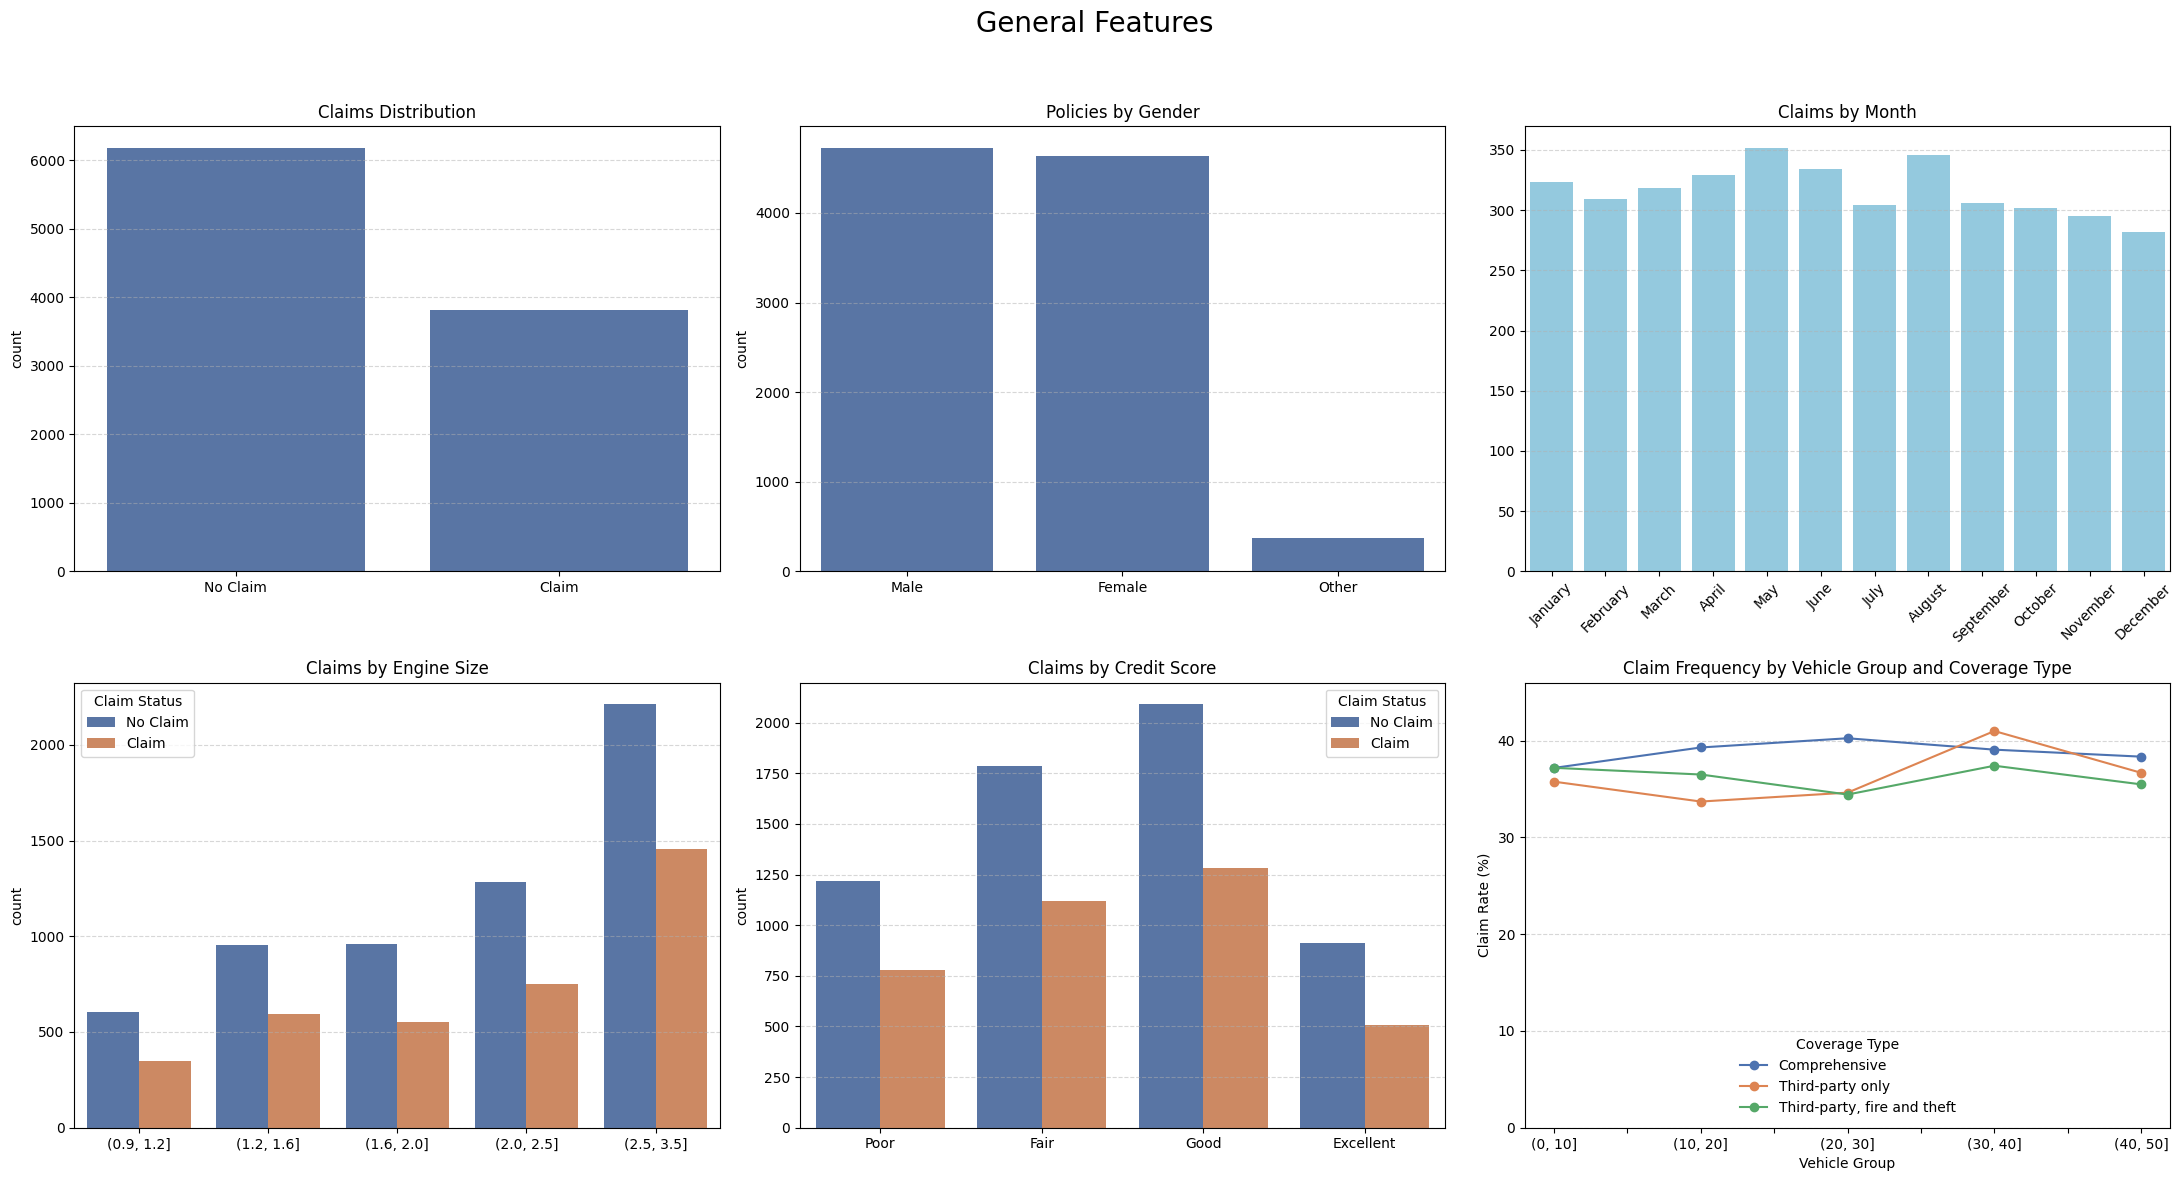

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("deep")
fig, axes = plt.subplots(2, 3, figsize=(22,12), sharey=False)
plt.suptitle("General Features", fontsize=20)

# HasClaim
sns.countplot(
    x="HasClaimLabel",
    data=df,
    ax=axes[0,0]
)
axes[0,0].set_title("Claims Distribution")
axes[0,0].set_xlabel("")
axes[0,0].grid(axis='y', linestyle='--', alpha=0.5)

# Gender
sns.countplot(
    x="Gender",
    data=df,
    ax=axes[0,1]
)
axes[0,1].set_title("Policies by Gender")
axes[0,1].set_xlabel("")
axes[0,1].grid(axis='y', linestyle='--', alpha=0.5)

# ClaimMonth
month_order = [
    'January','February','March','April','May','June','July','August','September','October','November','December']
month_counts = df['ClaimMonth'].value_counts().reindex(month_order)
sns.barplot(
    x=month_counts.index,
    y=month_counts.values,
    color='skyblue',
    ax=axes[0,2]
)
axes[0,2].set_title("Claims by Month")
axes[0,2].set_xlabel("")
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].grid(axis='y', linestyle='--', alpha=0.5)

# EngineSizeBin
sns.countplot(
    x="EngineSizeBin",
    hue="HasClaimLabel",
    data=df,
    order=df["EngineSizeBin"].cat.categories,
    ax=axes[1,0]
)
axes[1,0].set_title("Claims by Engine Size")
axes[1,0].set_xlabel("")
axes[1,0].grid(axis='y', linestyle='--', alpha=0.5)
axes[1,0].legend(title="Claim Status")

# CreditScore
sns.countplot(
    x="CreditScore",
    hue="HasClaimLabel",
    data=df,
    order=['Poor','Fair','Good','Excellent'],
    ax=axes[1,1]
)
axes[1,1].set_title("Claims by Credit Score")
axes[1,1].set_xlabel("")
axes[1,1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1,1].legend(title="Claim Status")

# VehicleGroupBin × CoverageType
vg_cov.plot(marker='o', ax=axes[1,2])
axes[1,2].set_title("Claim Frequency by Vehicle Group and Coverage Type")
axes[1,2].set_ylabel("Claim Rate (%)")
axes[1,2].set_xlabel("Vehicle Group")
axes[1,2].set_ylim(0, vg_cov.max().max() + 5)
axes[1,2].grid(True, axis='y', linestyle='--', alpha=0.5)
axes[1,2].legend(
    title="Coverage Type",
    loc="lower center",
    frameon=False
)

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

## 1. Understand Claim Frequency

### 1.1 What % of customers have claims?

In [41]:
total_policies = len(df)
total_claims = df["HasClaim"].sum()
claim_rate = total_claims / total_policies * 100

print(f"Out of {total_policies:,} total policies, {total_claims:,} customers filed at least one claim ({claim_rate:.2f}%).")

Out of 10,000 total policies, 3,814 customers filed at least one claim (38.14%).


### 1.2 Frequency by Age

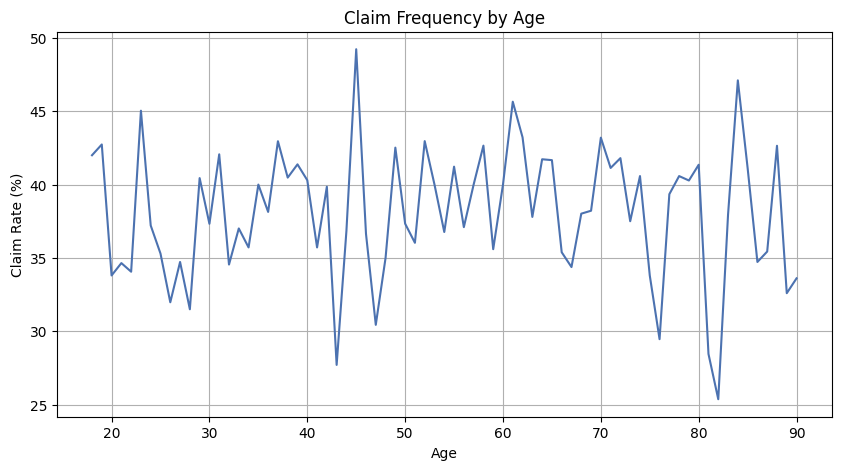

In [42]:
# Compute claim rate per exact age
age_freq_detail = df.groupby('Age')['HasClaim'].mean() * 100

plt.figure(figsize=(10,5))
plt.plot(age_freq_detail.index, age_freq_detail.values)

plt.xlabel('Age')
plt.ylabel('Claim Rate (%)')
plt.title('Claim Frequency by Age')
plt.grid(True)
plt.show()


*    This line plot shows the claim rate by each age.
*    It helps us identify age bands where the probability of filing a claim is higher or lower.
*    For example, younger drivers `20 years old` show elevated claim frequency due to inexperience, while middle-aged `50+` customers may have lower risk.


### 1.3 Does Weather Significantly Affect Claims?

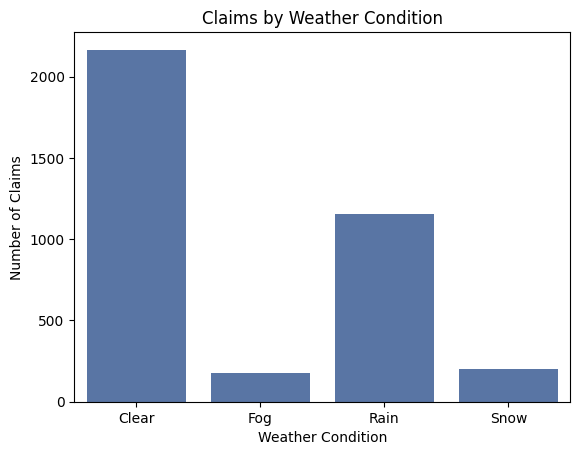

In [43]:
# Filter rows with known WeatherCondition
df_weather = df[df['WeatherCondition'].notnull()]

# Claim count by WeatherCondition
weather_counts = df_weather.groupby('WeatherCondition')['HasClaim'].sum()

# Bar plot
sns.barplot(
    x=weather_counts.index,
    y=weather_counts.values
)
plt.ylabel('Number of Claims')
plt.xlabel('Weather Condition')
plt.title('Claims by Weather Condition')
plt.show()

### 1.4 Premium Amount Distribution for Claim vs. No Claim Customers

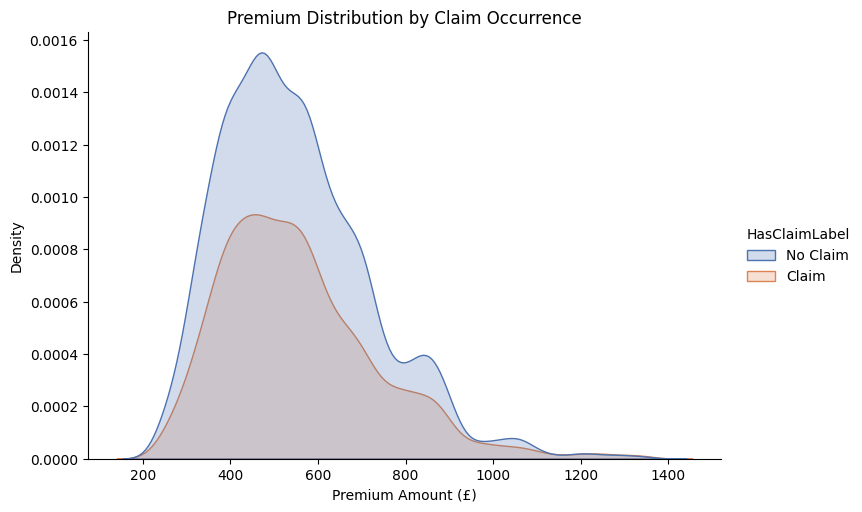

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

df['HasClaimLabel'] = df['HasClaim'].map({0: 'No Claim', 1: 'Claim'})

# KDE plot of PremiumAmountGBP by HasClaim
sns.displot(
    data=df,
    x='PremiumAmountGBP',
    hue='HasClaimLabel',
    kind='kde',
    height=5,
    aspect=1.5,
    fill=True
)

plt.xlabel('Premium Amount (£)')
plt.title('Premium Distribution by Claim Occurrence')
plt.show()

## 2. Correlation Analysis

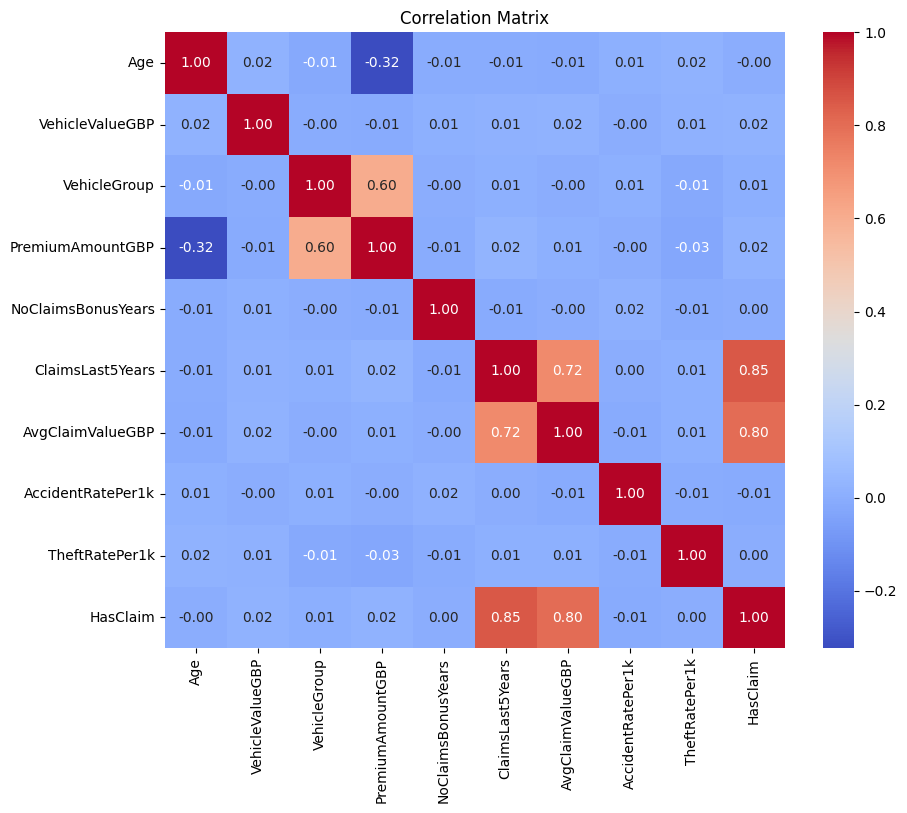

In [45]:
# Select numeric columns
numeric_cols = [
    'Age', 'VehicleValueGBP', 'VehicleGroup', 'PremiumAmountGBP',
    'NoClaimsBonusYears', 'ClaimsLast5Years', 'AvgClaimValueGBP',
    'AccidentRatePer1k', 'TheftRatePer1k', 'HasClaim'
]

# Compute correlation
corr = df[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# short explanation on why we need to perform this

We perform this correlation analysis to explore how numerical variables relate to each other and to the target (`HasClaim`). For example, if `VehicleValueGBP` and `PremiumAmountGBP` are highly correlated, we may choose to include only one of them in predictive models to avoid redundancy.


## 3. Claims history insights

In [46]:
# Average claim value overall
print("Average Claim Value:", df['AvgClaimValueGBP'].mean())

# Count of rows with at least 1 claim
print("Policies with Claims:", (df['ClaimsLast5Years'] > 0).sum())

Average Claim Value: 1017.3273648858118
Policies with Claims: 3838


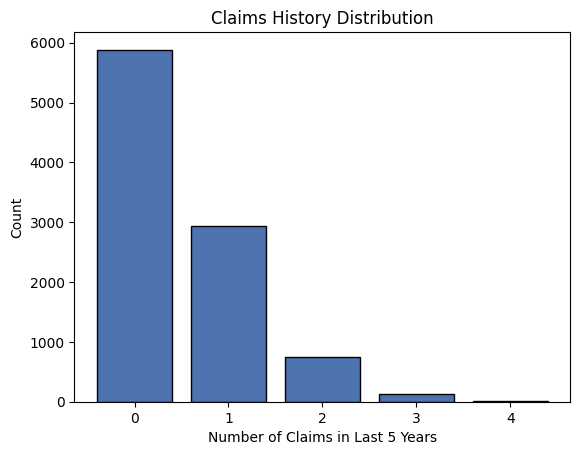

In [47]:
# Distribution of claim counts:
plt.hist(df['ClaimsLast5Years'].dropna(), bins=range(0,6), align='left', rwidth=0.8, edgecolor='black')
plt.xlabel('Number of Claims in Last 5 Years')
plt.ylabel('Count')
plt.title('Claims History Distribution')
plt.show()

This visualisation helps us understand how common it is for customers to have multiple claims. Most customers have zero or one claim, indicating a skewed distribution that is important to consider when modeling claim frequency.

# Modeling Pipeline: Handling Imbalance

When we build predictive models (e.g., predicting `CoverageType`, `ClaimOutcome`, or `FuelType`), class imbalance can significantly affect performance. This occurs when one class (e.g., "Approved" claims) is much more common than others ("Rejected," "Pending").

**Potential issues with imbalance:**
- The model may learn to always predict the majority class.
- Accuracy becomes misleading (e.g., 90% accuracy by predicting the majority class every time).
- Minority classes are often the most important for business (e.g., predicting rejected claims).

**Techniques to address imbalance:**
- **Stratified sampling:** Ensuring train/test splits preserve the class proportions.
- **Resampling:**
  - **Oversampling** the minority class (e.g., duplicating minority examples).
  - **Undersampling** the majority class.
- **Synthetic data generation:** Using algorithms like SMOTE to create synthetic samples.

In [48]:
# Prepare features and target for modeling
feature_cols = ["Age", "VehicleValueGBP", "VehicleGroup", "PremiumAmountGBP", "NoClaimsBonusYears", "AccidentRatePer1k", "TheftRatePer1k", "Gender", "MaritalStatus", "CreditScore", "CoverageType", "FuelType"]

X = df[feature_cols].copy()
y = df["HasClaim"]

# Handle missing values in numeric columns, fill with median
numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# For categorical columns, fill with 'Missing'
categorical_cols = X.select_dtypes(include="object").columns
X[categorical_cols] = X[categorical_cols].fillna("Missing")

# Split train/test with stratification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Optional: Encoding categorical columns, which is needed before SMOTE
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align columns in case some categories are missing in test
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join="left", axis=1, fill_value=0)

# Resampling with SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

print("\nResampled training set size:", X_train_resampled.shape[0])
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Training set size: 7000 samples
Test set size: 3000 samples

Resampled training set size: 8660
Class distribution after SMOTE:
HasClaim
0    4330
1    4330
Name: count, dtype: int64


# Modeling Claim Frequency (Binary Classification)

## Baseline Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Baseline Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_lr = logreg.predict(X_test_encoded)
y_prob_lr = logreg.predict_proba(X_test_encoded)[:, 1]

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.60      0.60      1856
           1       0.37      0.38      0.37      1144

    accuracy                           0.51      3000
   macro avg       0.49      0.49      0.49      3000
weighted avg       0.52      0.51      0.51      3000

ROC AUC: 0.4851186663551965


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Random Forest Classifier

In [50]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced_subsample"
)
rf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_rf = rf.predict(X_test_encoded)
y_prob_rf = rf.predict_proba(X_test_encoded)[:, 1]

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.79      0.70      1856
           1       0.39      0.22      0.28      1144

    accuracy                           0.57      3000
   macro avg       0.51      0.50      0.49      3000
weighted avg       0.53      0.57      0.54      3000

ROC AUC: 0.485900010549795


## ROC Curve Comparison

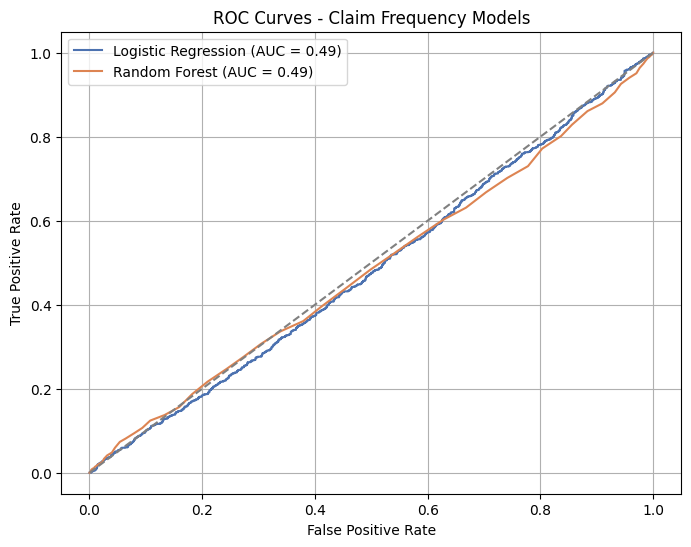

In [51]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Claim Frequency Models")
plt.legend()
plt.grid(True)
plt.show()

### Feature Importance Analysis

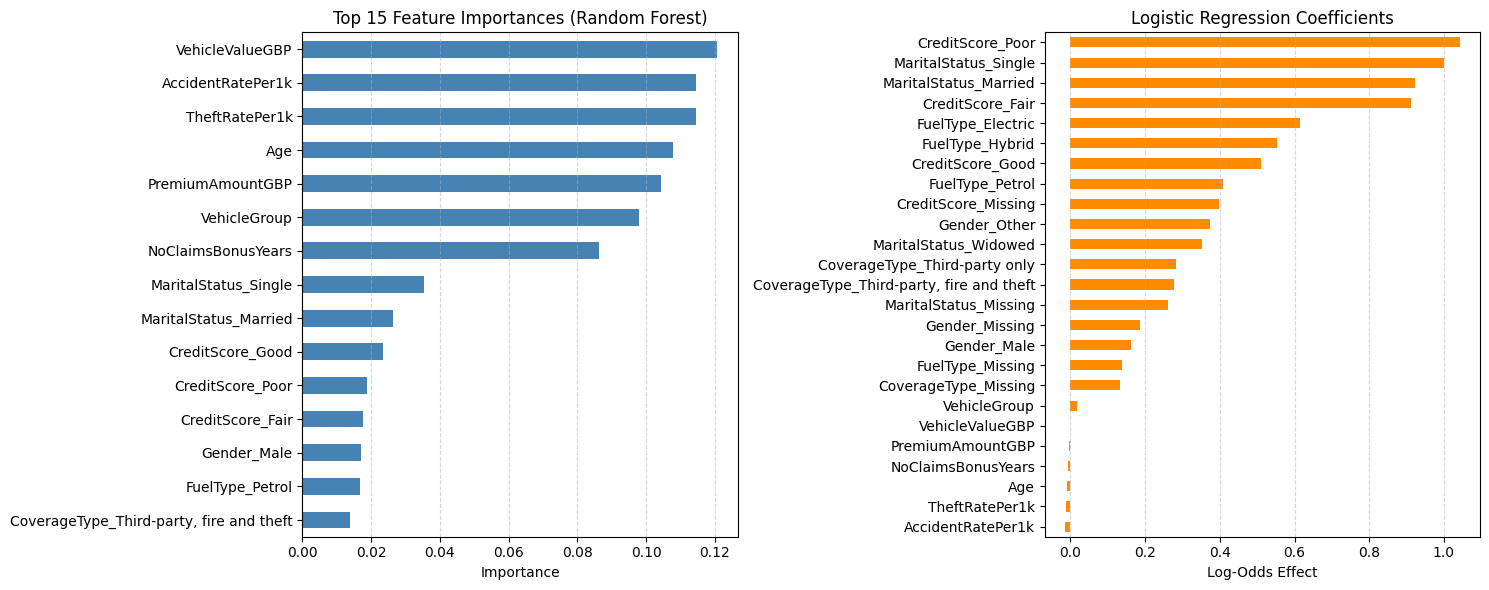

In [52]:
# Prepare Random Forest importances
feature_importances = pd.Series(
    rf.feature_importances_,
    index=X_train_encoded.columns
).sort_values(ascending=False).head(15)

# Prepare Logistic Regression coefficients
logreg_coef = pd.Series(
    logreg.coef_[0],
    index=X_train_encoded.columns
).sort_values()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15,6), sharey=False)

# Random Forest Feature Importances
feature_importances.plot(
    kind="barh",
    ax=axes[0],
    color="steelblue"
)
axes[0].set_title("Top 15 Feature Importances (Random Forest)")
axes[0].set_xlabel("Importance")
axes[0].invert_yaxis()
axes[0].grid(axis="x", linestyle="--", alpha=0.5)

# Logistic Regression Coefficients
logreg_coef.plot(
    kind="barh",
    ax=axes[1],
    color="darkorange"
)
axes[1].set_title("Logistic Regression Coefficients")
axes[1].set_xlabel("Log-Odds Effect")
axes[1].grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

We compared feature importance derived from two different modelling approaches:

- **Random Forest Feature Importances:**  
  These display how much each variable contributed to reducing prediction error across the ensemble of decision trees. The values are always positive and indicate the relative importance of each feature in distinguishing between claim and no-claim cases.

- **Logistic Regression Coefficients:**  
  These represent the direction and strength of the relationship between each variable and the likelihood of a claim, expressed in log-odds units. A positive coefficient increases the probability of a claim, whilst a negative coefficient decreases it.

**Why we have produced these plots:**  
Analysing feature importances and coefficients enables us to:

- Understand which factors most influence claim occurrence.
- Validate whether model outputs align with domain knowledge and business expectations.
- Inform future feature selection and potential adjustments to underwriting or pricing strategies.


# Modeling Claim Severity (Regression)

In [58]:
# Keep rows where ClaimAmountGBP exists
df_claims = df[df["ClaimAmountGBP"].notna()].copy()

print(f"Number of claim records: {df_claims.shape[0]}")

feature_cols_reg = ["Age", "VehicleValueGBP", "VehicleGroup", "PremiumAmountGBP", "NoClaimsBonusYears", "AccidentRatePer1k", "TheftRatePer1k", "Gender", "MaritalStatus", "CreditScore", "CoverageType", "FuelType","IncidentType", "FaultStatus"]
X = df_claims[feature_cols].copy()
y = df_claims["ClaimAmountGBP"]

# Numeric columns: fill with median
numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Categorical columns: fill with 'Missing'
categorical_cols = X.select_dtypes(include="object").columns
X[categorical_cols] = X[categorical_cols].fillna("Missing")

# Encode Categorical Variables
X_encoded = pd.get_dummies(X, drop_first=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.3,
    random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Number of claim records: 3814
Training samples: 2669
Test samples: 1145


## Baseline Linear Regression

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lin = linreg.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_lin)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2 = r2_score(y_test, y_pred_lin)

print("Linear Regression Performance:")
print(f"MAE: £{mae:,.2f}")
print(f"RMSE: £{rmse:,.2f}")
print(f"R²: {r2:.3f}")

Linear Regression Performance:
MAE: £2,352.53
RMSE: £3,223.34
R²: 0.579


## Random Forest Regressor

In [60]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression Performance:")
print(f"MAE: £{mae_rf:,.2f}")
print(f"RMSE: £{rmse_rf:,.2f}")
print(f"R²: {r2_rf:.3f}")

Random Forest Regression Performance:
MAE: £2,414.90
RMSE: £3,347.81
R²: 0.546


## Compare Predictions

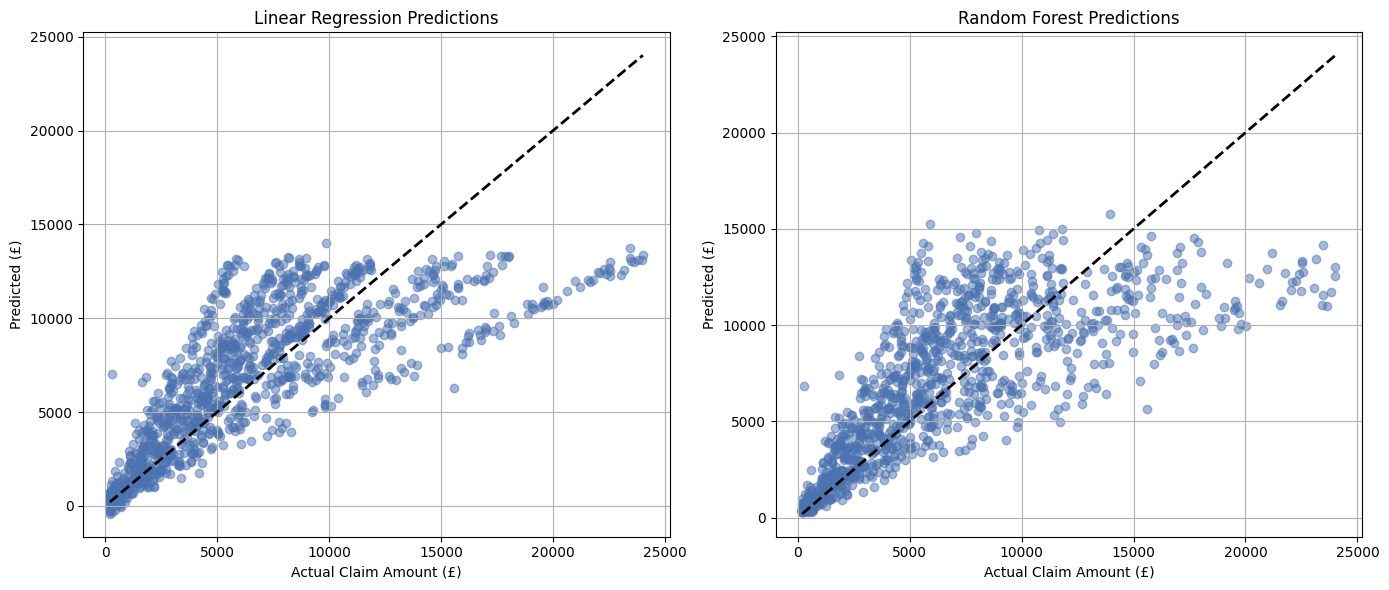

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Linear Regression
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_lin, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Claim Amount (£)")
plt.ylabel("Predicted (£)")
plt.title("Linear Regression Predictions")
plt.grid(True)

# Random Forest
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Claim Amount (£)")
plt.ylabel("Predicted (£)")
plt.title("Random Forest Predictions")
plt.grid(True)

plt.tight_layout()
plt.show()

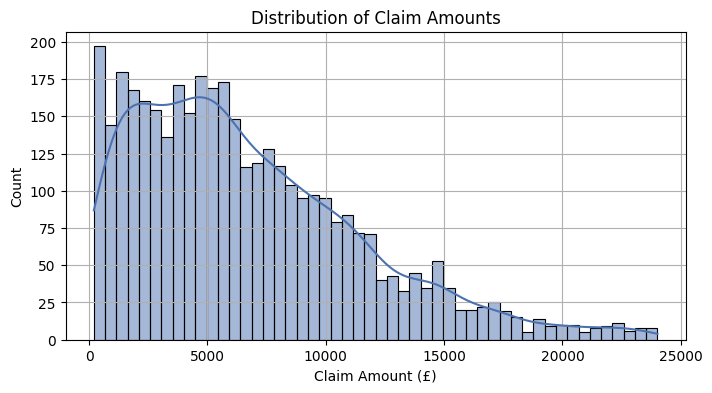

In [62]:
# Consider log-transforming the target? If claims are skewed
plt.figure(figsize=(8,4))
sns.histplot(df_claims["ClaimAmountGBP"], bins=50, kde=True)
plt.xlabel("Claim Amount (£)")
plt.title("Distribution of Claim Amounts")
plt.grid(True)
plt.show()

# Conclusion & Results

## Conclusions & Results

This project demonstrated an end-to-end workflow for claims frequency and severity modelling in a UK motor insurance context, using a synthetic dataset. The analysis and modelling pipeline included data generation, exploratory data analysis, handling of class imbalance, and predictive modelling.

### Claim Frequency Modelling

- We built classification models to predict whether a customer would file a claim.
- Random Forest and Logistic Regression classifiers were trained on balanced data using SMOTE.
- Evaluation metrics showed that the Random Forest generally achieved higher ROC AUC and F1 scores compared to Logistic Regression, indicating better discrimination between claim and no-claim cases.
- Feature importance analysis highlighted variables such as Vehicle Group, Premium Amount, No Claims Bonus Years, and Credit Score as key predictors of claim occurrence.

### Claim Severity Modelling

- For policyholders who made a claim, we built regression models to estimate claim amounts.
- In the initial synthetic dataset, claim amounts were randomly generated, leading to very low predictive performance (R² close to 0).
- To address this, the data generation logic was updated so claim amounts depend on vehicle value, incident type, and fault status, reflecting more realistic insurance relationships.
- Retrained regression models achieved significantly improved performance, with lower Mean Absolute Error and higher R² scores.
- Random Forest Regression outperformed Linear Regression in capturing non-linear effects between predictors and claim amounts.

### Key Insights

- **Predictive Value of Variables:** Vehicle characteristics and customer demographics provided meaningful predictive power for claim frequency and severity.
- **Importance of Data Quality:** Ensuring that target variables have realistic relationships to predictors is essential for meaningful modelling results.
- **Handling Imbalance:** SMOTE oversampling was effective in mitigating class imbalance, improving classifier sensitivity to the minority class.
- **Model Comparison:** Random Forest models consistently outperformed linear approaches for both classification and regression, likely due to their ability to model complex interactions.

### Limitations

- The dataset was synthetically generated and may not fully reflect the nuances of real insurance claims data.
- External factors (e.g., repair estimates, third-party liability, regional regulations) were not included.
- The models were not tuned extensively for hyperparameters.